<a href="https://colab.research.google.com/github/Aryaannn24/Reinforcement-Learning/blob/main/Prac3_Banditprob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing the Power socket

In [91]:
class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self):
        """ return an estimate of the socket's reward value """
        return self.Q

# Implementing the Charging Room

In [92]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

In [93]:
# create 5 sockets in a fixed order
socket_order = [3,5,2,1,4,6,7,8]

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)

In [94]:
# using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

# rewards will contain the charge returned at all of the time steps for each socket
rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))

# iterate through each of the sockets
for socket_number,socket in enumerate(sockets):

    # get charge from the socket for the defined number of steps
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()

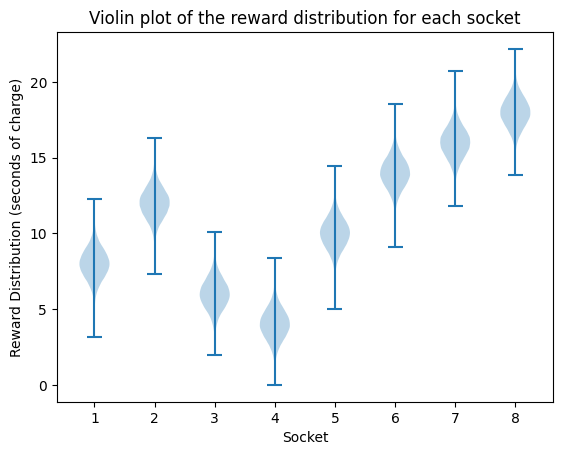

In [95]:
# plot the charge we got from the sockets
plt.violinplot(rewards)
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)')
plt.title('Violin plot of the reward distribution for each socket')
plt.show()

<ipython-input-96-4d660a617d50>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-96-4d660a617d50>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
sim

Text(0, 0.5, 'Density')

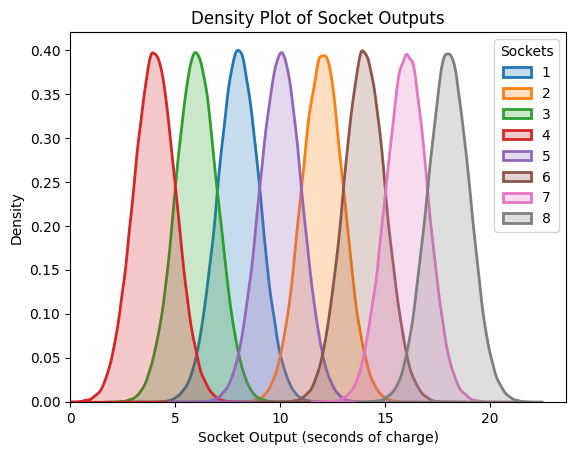

In [96]:
# iterate through the sockets to draw each plot
# (from: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');

# Plot formatting
plt.xlim(0, None)
plt.legend(title = 'Sockets')
plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')

In [97]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):

        # create supplied socket type with a mean value defined by socket order
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]

    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """

        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

    def select_socket( self, t ):
        """ choose the socket with the current highest mean reward or arbitrarily
            select a socket in the case of a tie """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index


    def run( self, number_of_steps, maximum_total_reward = float('inf')):
        """ perform a single run for the defined number of steps """

        for t in range(number_of_steps):
            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)

In [101]:
from PowerSocketSystem import *

In [102]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):

        # get the initial estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)


    def initialize(self):
        # estimate of this socket's reward value
        # - set to supplied initial value
        self.Q = self.initial_estimate

        # the number of times this socket has been tried
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if self.initial_estimate  > 0 else 0

In [103]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):
    '''
    highlight the entry before the column value changes
    '''
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')
    return style

In [104]:
# Test the optimistic socket over 30 time steps
tester = SocketTester( OptimisticSocket, initial_estimate = 20.)
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.11980997008106
Optimal Socket Selected = 0.759
Socket Percentages = [0.103 0.069 0.103 0.759 0.138]


In [105]:
# convert to a Pandas dataframe for table display & rename the columns to be 1-based
estimates = tester.socket_stats[:,:,0]
df = pd.DataFrame(estimates[:21])
df.columns = [1,2,3,4,5]

# show the estimates of each socket, highlighting the socket that has been selected for each time step
# - truncating to the first 20 time steps for clarity
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])

,1,2,3,4,5
0,20.000000,20.000000,20.000000,20.000000,20.000000
1,20.000000,11.400837,20.000000,20.000000,20.000000
2,20.000000,11.400837,20.000000,20.000000,15.000544
3,20.000000,11.400837,20.000000,16.269794,15.000544
4,20.000000,11.400837,13.940749,16.269794,15.000544
5,12.772891,11.400837,13.940749,16.269794,15.000544
6,12.772891,11.400837,13.940749,14.794773,15.000544
7,12.772891,11.400837,13.940749,14.794773,12.795794
8,12.772891,11.400837,13.940749,14.386114,12.795794
9,12.772891,11.400837,13.940749,13.631083,12.795794


Text(0, 0.5, 'Socket Reward Estimate')

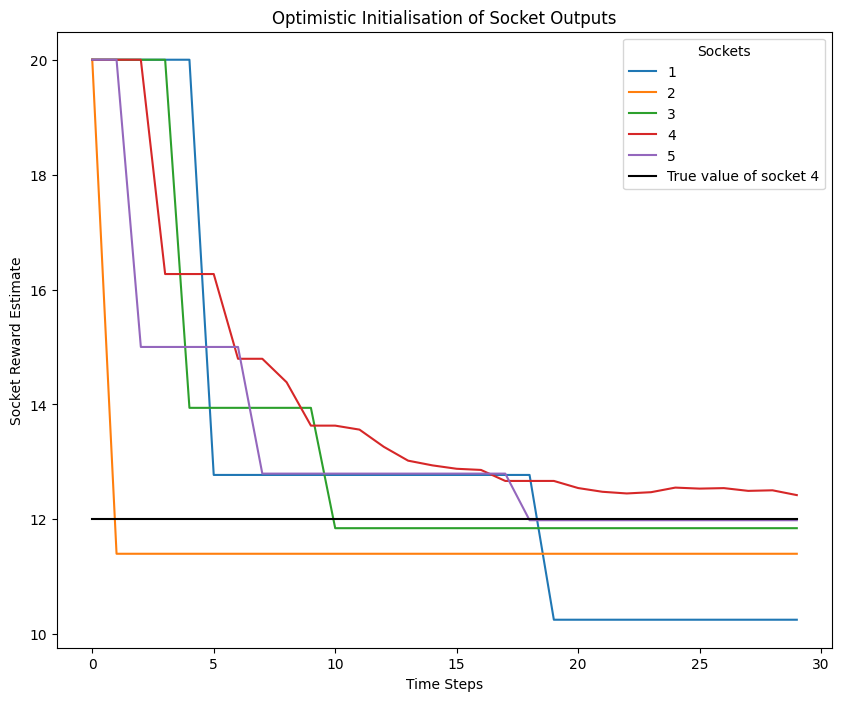

In [106]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

In [107]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)
    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r')

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')
    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')